In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [3]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

In [4]:
train.sample(frac=1).head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
444,445,1,3,"Johannesen-Bratthammer, Mr. Bernt",male,NaN,0,0,65306,8.1125,NaN,S
604,605,1,1,"Homer, Mr. Harry (""Mr E Haven"")",male,35.0,0,0,111426,26.5500,NaN,C
199,200,0,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,0,0,248747,13.0000,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [6]:
missing_val_df = pd.DataFrame(index=["Total", "Unique Cabin", "Missing Cabin"])
for name, df in zip(("Training data", "Test data"), (train, test)):
    total = df.shape[0]
    unique_cabin = len(df["Cabin"].unique())
    missing_cabin = df["Cabin"].isnull().sum()
    missing_val_df[name] = [total, unique_cabin, missing_cabin]
missing_val_df

,Training data,Test data
Total,891,418
Unique Cabin,148,77
Missing Cabin,687,327


In [7]:
train.drop("PassengerId", axis=1, inplace=True)
for df in train, test:
    df.drop("Cabin", axis=1, inplace=True)

Text(0.5,1,'Bar plot of embarked in Southampton, Queenstown, Cherbourg')

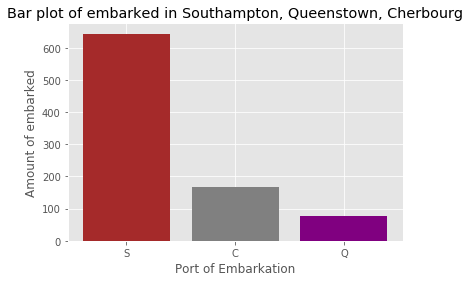

In [8]:
non_empty_embarked = train["Embarked"].dropna()
unique_values, value_counts = non_empty_embarked.unique(), non_empty_embarked.value_counts()
X = np.arange(len(unique_values))
colors = ["brown", "grey", "purple"]
    
plt.bar(left=X,
        height=value_counts,
        color=colors,
        tick_label=unique_values)
plt.xlabel("Port of Embarkation")
plt.ylabel("Amount of embarked")
plt.title("Bar plot of embarked in Southampton, Queenstown, Cherbourg")

[Text(0,0.5,'Amount'), Text(0.5,0,'Age'), Text(0.5,1,'Dead')]

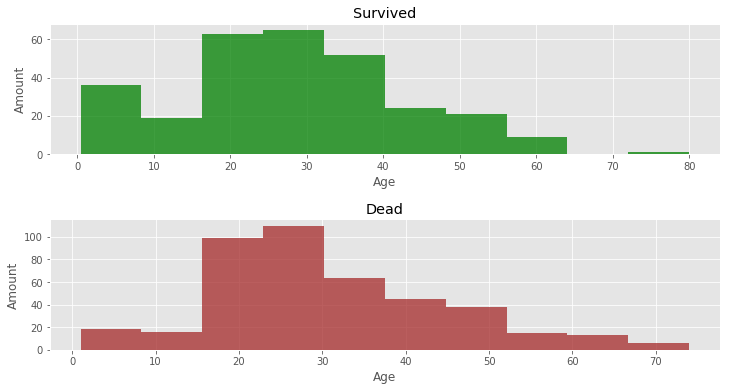

In [9]:
survived = train[train["Survived"] == 1]["Age"].dropna()
perished = train[train["Survived"] == 0]["Age"].dropna()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(12, 6)
fig.subplots_adjust(hspace=0.5)
ax1.hist(survived, facecolor='green', alpha=0.75)
ax1.set(title="Survived", xlabel="Age", ylabel="Amount")
ax2.hist(perished, facecolor='brown', alpha=0.75)
ax2.set(title="Dead", xlabel="Age", ylabel="Amount")

[Text(0,0.5,'Amount'), Text(0.5,0,'Age'), Text(0.5,1,'Dead')]

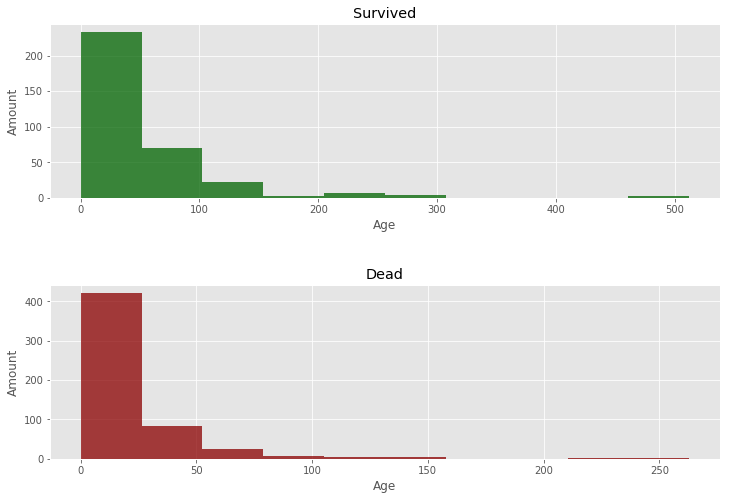

In [10]:
survived = train[train["Survived"] == 1]["Fare"].dropna()
perished = train[train["Survived"] == 0]["Fare"].dropna()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(12, 8)
fig.subplots_adjust(hspace=0.5)
ax1.hist(survived, facecolor='darkgreen', alpha=0.75)
ax1.set(title="Survived", xlabel="Age", ylabel="Amount")
ax2.hist(perished, facecolor='darkred', alpha=0.75)
ax2.set(title="Dead", xlabel="Age", ylabel="Amount")

In [11]:
# We can clean up Age and Fare columns filling in all of the missing values with median of all values in the training set.
for df in train, test:
    df["Embarked"].fillna("S", inplace=True)
    for feature in "Age", "Fare":
        df[feature].fillna(train[feature].mean(), inplace=True)

In [12]:
for df in train, test:
    df.drop("Ticket", axis=1, inplace=True)

In [13]:
for df in train, test:
    df["Embarked"] = df["Embarked"].map(dict(zip(("S", "C", "Q"), (0, 1, 2))))
    df["Sex"] = df["Sex"].map(dict(zip(("female", "male"), (0, 1))))

In [14]:
for df in train, test:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

In [15]:
for df in train, test:
    titles = list()
    for row in df["Name"]:
        surname, title, name = re.split(r"[,.]", row, maxsplit=2)
        titles.append(title.strip())
    df["Title"] = titles
    df.drop("Name", axis=1, inplace=True)

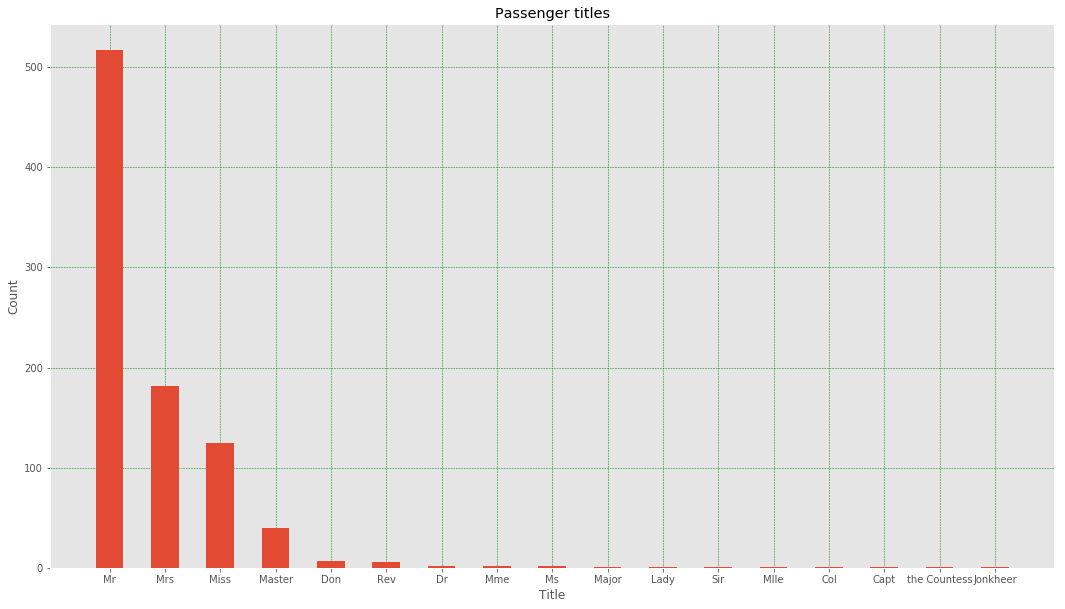

In [16]:
title = train["Title"]
unique_values, value_counts = title.unique(), title.value_counts()
X = np.arange(len(unique_values))

fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
ax.bar(left=X, height=value_counts, width=0.5, tick_label=unique_values)
ax.set_xlabel("Title")
ax.set_ylabel("Count")
ax.set_title("Passenger titles")
ax.grid(color='g', linestyle='--', linewidth=0.5)

In [17]:
for df in train, test:
    for key, value in zip(("Mr", "Mrs", "Miss", "Master", "Dr", "Rev"),
                          np.arange(6)):
        df.loc[df["Title"] == key, "Title"] = value
    df.loc[df["Title"] == "Ms", "Title"] = 1
    for title in "Major", "Col", "Capt":
        df.loc[df["Title"] == title, "Title"] = 6
    for title in "Mlle", "Mme":
        df.loc[df["Title"] == title, "Title"] = 7
    for title in "Don", "Sir":
        df.loc[df["Title"] == title, "Title"] = 8
    for title in "Lady", "the Countess", "Jonkheer":
        df.loc[df["Title"] == title, "Title"] = 9
test["Title"][414] = 0

In [18]:
# Nominal features of our model.
train.sample(frac=1).head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Title
86,0,3,1,16.0,1,3,34.3750,0,5,0
156,1,3,0,16.0,0,0,7.7333,2,1,2
208,1,3,0,16.0,0,0,7.7500,2,1,2
805,0,3,1,31.0,0,0,7.7750,0,1,0
677,1,3,0,18.0,0,0,9.8417,0,1,2
73,0,3,1,26.0,1,0,14.4542,1,2,0
847,0,3,1,35.0,0,0,7.8958,1,1,0
476,0,2,1,34.0,1,0,21.0000,0,2,0
823,1,3,0,27.0,0,1,12.4750,0,2,1
610,0,3,0,39.0,1,5,31.2750,0,7,1


In [19]:
# Choose the most informative predictors and randomly split the training data.
from sklearn.model_selection import train_test_split

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch",
              "Fare", "Embarked", "FamilySize", "Title"]
X_train, X_test, y_train, y_test = train_test_split(train[predictors], train["Survived"])

In [20]:
# Build a Random Forest model from the training set and evaluate the mean accuracy on the given test set.

In [21]:
forest = RandomForestClassifier(n_estimators=100,
                                criterion='gini',
                                max_depth=5,
                                min_samples_split=10,
                                min_samples_leaf=5,
                                random_state=0)
forest.fit(X_train, y_train)
print("Random Forest score: {0:.2}".format(forest.score(X_test, y_test)))

Random Forest score: 0.87


([<matplotlib.axis.XTick at 0x1a096d0>,
 <a list of 9 Text xticklabel objects>)

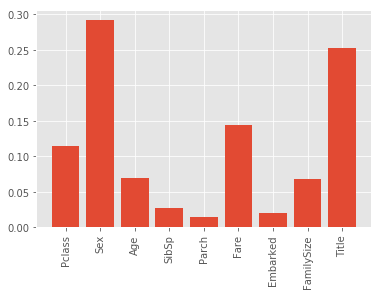

In [23]:
# Examine the feature importances.
plt.bar(np.arange(len(predictors)), forest.feature_importances_)
plt.xticks(np.arange(len(predictors)), predictors, rotation='vertical')

In [25]:
# Pick the best features and make a submission.
predictors = ["Title", "Sex", "Fare", "Pclass", "Age", "FamilySize"]
clf = RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                             max_depth=5,
                             min_samples_split=10,
                             min_samples_leaf=5,
                             random_state=0)
clf.fit(train[predictors], train["Survived"])
prediction = clf.predict(test[predictors])

submission = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": prediction})
submission.to_csv("submission.csv", index=False)